In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data preparation

In [6]:
# Custom Dataset class
class ToxicityDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the CSV file into a pandas DataFrame
        self.data = pd.read_csv(csv_file)

        # Extract features (X) and labels (y)
        self.X = self.data.iloc[
            :, 1:
        ].values  # All columns except the last one (features)
        self.y = (
            self.data["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0).values
        )  # Binary labels

        # Normalize features (optional)
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)  # Normalize features

        # Convert to PyTorch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32).view(
            -1, 1
        )  # Ensure y is of shape [batch_size, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get the features and labels for the given index
        return self.X[idx], self.y[idx]


# Prepare DataLoader
def prepare_dataloader(train_file, test_file, batch_size=32):
    # Create dataset instances
    train_dataset = ToxicityDataset(train_file)
    test_dataset = ToxicityDataset(test_file)

    # Create DataLoaders for batching
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [9]:
# Load training and testing data
train_file = "data/training_class.CSV"
test_file = "data/testing_class.CSV"

# Prepare the DataLoaders
train_loader, test_loader = prepare_dataloader(train_file, test_file)

In [8]:
# for data in train_loader:
#     print(data)
#     break

[tensor([[ 2.3519,  1.9615, -0.3024,  ...,  0.0000,  0.0000, -0.0944],
        [-0.4252, -0.5098, -0.3024,  ...,  0.0000,  0.0000, -0.0944],
        [-0.4252, -0.5098, -0.3024,  ...,  0.0000,  0.0000, -0.0944],
        ...,
        [-0.4252, -0.5098,  3.3065,  ...,  0.0000,  0.0000, -0.0944],
        [-0.4252, -0.5098, -0.3024,  ...,  0.0000,  0.0000, -0.0944],
        [-0.4252, -0.5098, -0.3024,  ...,  0.0000,  0.0000, -0.0944]]), tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]])]


In [25]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for X_batch, y_batch in data_loader:
        # Move X_batch and y_batch to the device (CPU or GPU)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()  # Reset gradients
        out = model(X_batch)  # Forward pass

        loss = criterion(out, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Track metrics
        total_loss += loss.item()

        # Predictions: since this is binary classification, apply a threshold of 0.5
        pred = (
            out > 0.5
        ).float()  # Sigmoid outputs probabilities, so threshold at 0.5 for class prediction
        correct += (pred == y_batch).sum().item()  # Count correct predictions

        # For AUC calculation, use raw output probabilities for class 1 (out is already the sigmoid probability)
        y_true.extend(
            y_batch.cpu().tolist()
        )  # Move true labels back to CPU for metrics
        y_pred.extend(out.detach().cpu().numpy())  # Use the output probabilities

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [30]:
# Testing/Validation function with AUC and accuracy tracking
def test(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for X_batch, y_batch in data_loader:
            # Move X_batch and y_batch to the device (CPU or GPU)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            out = model(X_batch)

            # Compute loss
            loss = criterion(out, y_batch)
            total_loss += loss.item()

            # Predictions: apply a threshold of 0.5 for binary classification
            pred = (
                out > 0.5
            ).float()  # Convert sigmoid outputs to binary class (0 or 1)
            correct += (pred == y_batch).sum().item()  # Count correct predictions

            # Track true labels and predicted probabilities for AUC
            y_true.extend(y_batch.cpu().tolist())  # Move true labels back to CPU
            y_pred.extend(
                out.detach().cpu().numpy()
            )  # Use output probabilities from sigmoid

    # Compute accuracy and AUC
    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

# Define 1D-CNN model

In [21]:
class DILI1DCNNModel(nn.Module):
    def __init__(
        self, input_length=16093, num_classes=1, num_filters=32, hidden_dim=128
    ):
        super(DILI1DCNNModel, self).__init__()

        # 1D Convolutional layers (input_length is the number of features per input sequence)
        self.conv1 = nn.Conv1d(
            in_channels=1, out_channels=num_filters, kernel_size=3, padding=0
        )
        self.conv2 = nn.Conv1d(
            in_channels=num_filters,
            out_channels=num_filters * 2,
            kernel_size=3,
            padding=0,
        )
        self.conv3 = nn.Conv1d(
            in_channels=num_filters * 2,
            out_channels=num_filters * 3,
            kernel_size=3,
            padding=0,
        )

        # Global Max Pooling
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(num_filters * 3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc_out = nn.Linear(512, num_classes)

        # Dropout Layer
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Ensure input is in [batch_size, num_features, sequence_length] format for Conv1d
        x = x.unsqueeze(
            1
        )  # Add a channel dimension for Conv1d: [batch_size, 1, input_length]

        # Convolutional Layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        # Global Max Pooling
        x = self.global_max_pool(x)
        x = x.squeeze(-1)  # Remove the last dimension after pooling

        # Fully Connected Layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)

        # Output Layer (Sigmoid activation for binary classification)
        out = torch.sigmoid(self.fc_out(x))
        return out

# Training

In [31]:
# Initialize the model, optimizer, and loss function
model = DILI1DCNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
max_epochs = 1000  # Max epochs
patience = 100  # Early stopping patience

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

for epoch in range(max_epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    print(f"Epoch {epoch+1}:")
    print(
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}"
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}"
    )

    # Early stopping
    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0  # Reset counter if improvement
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1:
Train Loss: 0.0000, Train Acc: 0.4972, Train AUC: 0.4920
Test Loss: 0.0000, Test Acc: 0.7727, Test AUC: 0.5184
Epoch 2:
Train Loss: 0.0000, Train Acc: 0.4641, Train AUC: 0.4819
Test Loss: 0.0000, Test Acc: 0.2273, Test AUC: 0.5000
Epoch 3:
Train Loss: 0.0000, Train Acc: 0.4899, Train AUC: 0.4816
Test Loss: 0.0000, Test Acc: 0.2273, Test AUC: 0.5000
Epoch 4:
Train Loss: 0.0000, Train Acc: 0.5230, Train AUC: 0.5049
Test Loss: 0.0000, Test Acc: 0.2273, Test AUC: 0.5000
Epoch 5:
Train Loss: 0.0000, Train Acc: 0.4827, Train AUC: 0.4917
Test Loss: 0.0000, Test Acc: 0.7727, Test AUC: 0.5000
Epoch 6:
Train Loss: 0.0000, Train Acc: 0.4778, Train AUC: 0.4968
Test Loss: 0.0000, Test Acc: 0.2273, Test AUC: 0.5000
Epoch 7:
Train Loss: 0.0000, Train Acc: 0.4496, Train AUC: 0.5000
Test Loss: 0.0000, Test Acc: 0.2273, Test AUC: 0.5000
Epoch 8:
Train Loss: 0.0000, Train Acc: 0.4496, Train AUC: 0.5000
Test Loss: 0.0000, Test Acc: 0.2273, Test AUC: 0.5000
Epoch 9:
Train Loss: 0.0000, Train Acc: 

## 4. Evaluation function

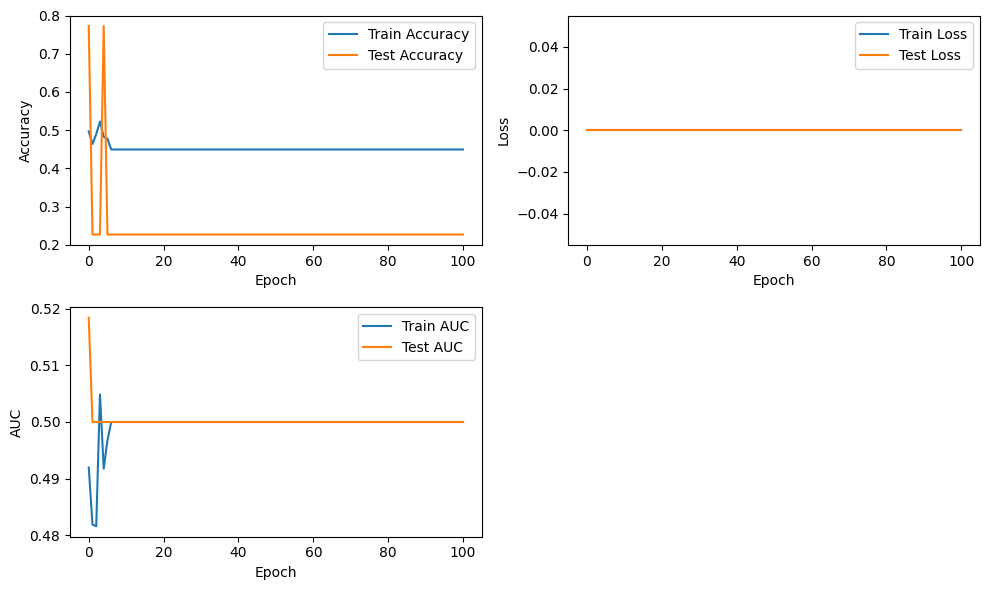

In [32]:
# Plot training and testing accuracy
from matplotlib import pyplot as plt


epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()